In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output

In [49]:
class WeightsInitialization:
    def __init__(self, L_in, L_out):
        self.L_in = L_in
        self.L_out = L_out
        self.weight = None

    def InitializeLayer(self):
        L = np.random.rand(self.L_out, self.L_in + 1) * 2 - 1
        self.weight = (L - np.mean(L)) / np.std(L)

In [21]:
class Network:
    def __init__(self,layers,reg={'penalty':None,'lamda':0},opt={'optimizer':None},read_freq=0):
        self.w=[]
        self.v=[]
        self.s=[]
        self.ai=[]
        self.train_cost=[]
        self.test_cost=[]
        self.layers=layers
        self.plot_iters1 = 0
        self.plot_iters2 = 0
        self.opt = opt
        self.reg = reg
        self.read_freq = read_freq
        
        for i in range(len(self.layers)-1):
            wi=WeightsInitialization(self.layers[i],self.layers[i+1])
            self.w.append(wi)
            self.w[i].InitializeLayer()
            
        if(self.opt['optimizer']=='momentum' or self.opt['optimizer']=='RMSprop'):
            self.beta = self.opt['beta']
            if(self.opt['optimizer']=='RMSprop'):
                self.E = self.opt['epsilon']
            for i in range(len(self.layers)-1):
                vi = np.zeros(self.w[i].weight.shape)
                self.v.append(vi)
            
        if(self.opt['optimizer']=='adam'):
            self.beta1 = self.opt['beta1']
            self.beta2 = self.opt['beta2']
            self.E = self.opt['epsilon']
            
            for i in range(len(self.layers)-1):
                vi = np.zeros(self.w[i].weight.shape)
                si = np.zeros(self.w[i].weight.shape)
                self.v.append(vi)
                self.s.append(si)
            
               
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def d_sigmoid(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def ForwardProp(self,w,x):
        self.ai=[]
        self.ai.append(x)
        input=x
        for i in range(len(self.layers)-1):
            b=self.w[i].weight[:,0].reshape(self.w[i].weight[:,0].shape[0],1)
            hyp=self.sigmoid(np.dot(self.w[i].weight[:,1:],input.T)+b).T
            input=hyp
            self.ai.append(hyp)
        
        return hyp
    
    def BackProp(self,h,y,l_rate,t):
        error = h.T - y
        for i in range(len(self.layers)-2,-1,-1):
            delta = error*self.d_sigmoid(self.ai[i+1]).T
    
            w_update = np.dot(delta,self.ai[i])
            b_update = delta.sum()
            
            #regularization
            if(self.reg['penalty']=='L2'):
                w_update += self.reg['lamda'] * self.w[i].weight[:,1:]
                    
            if(self.reg['penalty']=='L1'):
                w_update += self.reg['lamda']/2
                
                
            # optimization
            if(self.opt['optimizer']=='momentum'):
                self.v[i][:,1:] = self.beta*self.v[i][:,1:] + (1-self.beta)*w_update
                self.v[i][:,0] = self.beta*self.v[i][:,0] + (1-self.beta)*b_update
                
                self.w[i].weight[:,1:]-=(l_rate/len(y.T))*self.v[i][:,1:] #weights
                self.w[i].weight[:,0]-=(l_rate/len(y.T))*self.v[i][:,0]  #bias
                
            if(self.opt['optimizer']=='RMSprop'):
                self.v[i][:,1:] = self.beta*self.v[i][:,1:] + (1-self.beta)*(w_update**2)
                self.v[i][:,0] = self.beta*self.v[i][:,0] + (1-self.beta)*(b_update**2)
                
                self.w[i].weight[:,1:]-=(l_rate/(len(y.T)*(np.sqrt(self.v[i][:,1:])+self.E)))*w_update #weights
                self.w[i].weight[:,0]-=(l_rate/(len(y.T)*(np.sqrt(self.v[i][:,0])+self.E)))*b_update  #bias
                
            if(self.opt['optimizer']=='adam'):
                self.v[i][:,1:] = (self.beta1*self.v[i][:,1:] + (1-self.beta1)*w_update)
                self.v[i][:,0] = (self.beta1*self.v[i][:,0] + (1-self.beta1)*b_update)
                
                self.s[i][:,1:] = (self.beta2*self.s[i][:,1:] + (1-self.beta2)*(w_update**2))
                self.s[i][:,0] = (self.beta2*self.s[i][:,0] + (1-self.beta2)*(b_update**2))
                
                if(self.opt['bias_correction']==True):
                    self.v[i][:,1:] = self.v[i][:,1:]/(1-self.beta1**t)
                    self.v[i][:,0] = self.v[i][:,0]/(1-self.beta1**t)
                    self.s[i][:,1:] = self.v[i][:,1:]/(1-self.beta2**t)
                    self.s[i][:,0] = self.v[i][:,0]/(1-self.beta2**t)
                
                self.w[i].weight[:,1:]-=(l_rate/(len(y.T)*(np.sqrt(self.s[i][:,1:])+self.E)))*self.v[i][:,1:] #weights
                self.w[i].weight[:,0]-=(l_rate/(len(y.T)*(np.sqrt(self.s[i][:,0])+self.E)))*self.v[i][:,0]  #bias
                
                           
            if(self.opt['optimizer']==None):           
                self.w[i].weight[:,1:]-=(l_rate/len(y.T))*w_update #weights
                self.w[i].weight[:,0]-=(l_rate/len(y.T))*b_update  #bias
            
            
            error = np.dot(self.w[i].weight[:, 1:].T, delta)
            
    
    def costFunc(self,hyp,y,m,plot_unregularised_cost):
        cost =  np.sum(np.subtract(hyp, y) ** 2) / m
        
        if(not plot_unregularised_cost):
            if(self.reg['penalty']=='L2'):
                s = 0
                for i in nn.w:
                    s+=np.sum(np.square(i.weight))
                cost += (self.reg['lamda']/2*m) * s


            if(self.reg['penalty']=='L1'):
                s = 0
                for i in nn.w:
                    s+=np.sum(i.weight)
                cost += (self.reg['lamda']/2*m) * s

        return cost
    
    
    def l_curves(self,l_rate):
        sns.set()
        plt.figure(dpi=100,figsize=(6,4))
        iters = [i * self.read_freq for i in range(self.plot_iters1)]
        plt.plot(iters, self.train_cost,color="red",label="train loss")
        if(len(self.test_cost)!=0):
                plt.plot(iters, self.test_cost,color="green",label="test loss")
        plt.xlabel("iterations")
        plt.ylabel("cost")
        plt.title("learning curve")
        plt.legend()
        plt.show()
        
    
    def Train(self,x,y,iters,l_rate,mini_batch_size,test_loss = {},plot_unregularised_cost=True):
        print("\nTraining...")
        mini_batches_x = np.array([x[i:i+mini_batch_size] for i in range(0,len(x),mini_batch_size)])
        mini_batches_y = np.array([y[i:i+mini_batch_size] for i in range(0,len(y),mini_batch_size)])
        
        
        for i in range(iters+1):
            for X,Y in zip(mini_batches_x,mini_batches_y):
                h = self.ForwardProp(self.w,X)
                self.BackProp(h,Y.T,l_rate,i+1)
                
            
            if i % self.read_freq == 0:
                train_cost=self.costFunc(h, Y, len(X),plot_unregularised_cost)
                self.train_cost.append(train_cost)
                self.plot_iters1+=1
                print("\niteration :",i," train cost:",train_cost)
            
            if(len(test_loss)!=0):
                test_h = self.ForwardProp(self.w,test_loss['X_test'])
                test_cost=self.costFunc(test_h, test_loss['y_test'], len(test_loss['X_test']),plot_unregularised_cost)
                self.test_cost.append(test_cost)
                self.plot_iters2+=1
                print("\niteration :",i," test cost:",test_cost)
            
            clear_output(wait=True)
        
    
    def predict(self, x):
        h = self.ForwardProp(self.w,x) 
        return np.argmax(h,axis=1)
    
    def accuracy(self,x,y):
        y_pred = self.predict(x)
        return (((y_pred == y).astype(int)).mean())*100

In [4]:
def Transform(y):
    for i in range(len(y)):
        y1=np.zeros(10)
        y1[y[i]]=1
        y[i]=y1
        
    return y      


time taken to train : 5.43 s



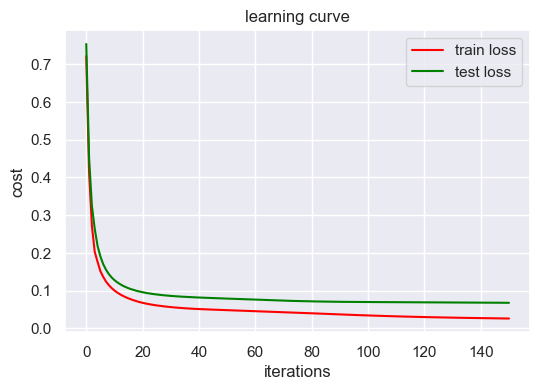



training accuracy: 99.244 %

test accuracy: 96.667 %


In [50]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

x=np.array([digits.data[i] for i in range(1700)])
y=np.array(Transform([digits.target[i] for i in range(1700)]))

x = (x - np.mean(x))/(np.max(x))
y = (y - np.mean(x))/(np.max(y))

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3)


nn=Network([64,32,10],{'penalty':'L2','lamda':10**-3},{'optimizer':'adam','beta1':0.9,'beta2':0.999,'epsilon':10**-8,'bias_correction':False},read_freq=1)
learning_rate=0.8

print("\nTraining...")

st=time.time()
nn.Train(X_train,y_train,iters=150,l_rate=learning_rate,mini_batch_size=85,test_loss={'X_test':X_test,'y_test':y_test},plot_unregularised_cost=True)  
et=time.time()

print("\ntime taken to train : %0.2f"%(et-st),"s\n")

nn.l_curves(l_rate=learning_rate)
    
print("\n\ntraining accuracy: %0.3f" % nn.accuracy(X_train, np.argmax(y_train,axis=1)), "%")

#pred = nn.predict(X_test)

#print("\nprediction:",list(pred)) 

#print("\nreal:",list(np.argmax(y_test,axis=1)))

print("\ntest accuracy: %0.3f" % nn.accuracy(X_test, np.argmax(y_test,axis=1)), "%")
